In [1]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import pandas as pd
from pandas import DataFrame, Series

### Solving the system of differential equations

In [2]:
# System of 1st order equations used by calling integrate.odeint function
def pend(I, t, m, k, l, g):
    dy1dt = I[1]                                                  # y1' = x'
    dy2dt = (-k/m)*I[0] + (l+I[0])*(I[3])**2 + g*math.cos(I[2])   # y2' = x"
    dy3dt = I[3]                                                  # y3' = theta' 
    dy4dt = (-g*math.sin(I[2]) - (2.0*I[1]*I[3])) / (l+I[0])      # y4' = theta" 
    return [dy1dt, dy2dt, dy3dt, dy4dt]

### Performing the Monte Carlo simulation

In [ ]:
# Initialize data frames for results
angleData = DataFrame() 
angleFailureData = DataFrame()
stretchData = DataFrame()
stretchFailureData = DataFrame()
parameterData = DataFrame() 

# Run the Monte Carlo
t = np.linspace(0, 30, 100000) # time array

for trial in range(100):
    
    #defining parameters
    mass = norm.rvs(1.0, 0.1)             # pendulum mass (kilograms)
    spring = norm.rvs(30.0, 0.25)         # spring constant (Newtons/meter)
    length = norm.rvs(1.0, 0.1)           # unstretched pendulum length (meters)
    gravity = norm.rvs(9.8, 0.1)          # acceleration due to gravity (meters/second^2)
    
    #defining initial conditions
    initStretch = norm.rvs(0.1, 0.01)     # initial stretch (meters)
    initStretchPrime = 0                  # initial rate of change in stretch (meters/second)
    initAngle = norm.rvs(0.175, 0.01)     # initial angle of swing (radians) (about N(10, 0.6) in degrees)
    initAnglePrime = 0                    # initial rate of change in angle (radians/second)
    
    initial_conditions = [initStretch, initStretchPrime, initAngle, initAnglePrime]    

    # calling odeint
    results = DataFrame(integrate.odeint(pend, initial_conditions, t, 
                                         args=(mass, spring, length, gravity)))    
    
    stretchSeries = Series(results[0])
    angleSeries = Series(results[2])
   
    # Define performance metric
    if (angleSeries.max() > math.radians(21)):     
        angleFailureData = pd.concat( [angleFailureData, angleSeries], axis=1 )
        angleFailureData = angleFailureData.rename( columns={ 2:'trial'+str(trial) } )
        stretchFailureData = pd.concat( [stretchFailureData, stretchSeries], axis=1 )
        stretchFailureData = stretchFailureData.rename( columns={ 0:'Trial '+str(trial) } )
        parameterData = pd.concat( [parameterData, Series( {'Mass':mass, 'Spring':spring, 
                                   'Length':length, 'Gravity':gravity, 
                                   'Initial Stretch':initStretch, 'Initial Angle':initAngle,
                                   'Success':0} ) ], axis=1 )
        parameterData = parameterData.rename( columns={ 0:'Trial '+str(trial) } )        
        
    else:
        angleData = pd.concat( [angleData, angleSeries], axis=1 ) 
        angleData = angleData.rename( columns={ 2:'Trial '+str(trial) } )    
        stretchData = pd.concat( [stretchData, stretchSeries], axis=1 )
        stretchData = stretchData.rename( columns={ 0:'Trial '+str(trial) } )
        parameterData = pd.concat( [parameterData, Series( {'Mass':mass, 'Spring':spring,
                                   'Length':length, 'Gravity':gravity,
                                   'Initial Stretch':initStretch, 'Initial Angle':initAngle,
                                   'Success':1} ) ], axis=1 )
        parameterData = parameterData.rename( columns={ 0:'Trial '+str(trial) } )

### Plotting angle over time

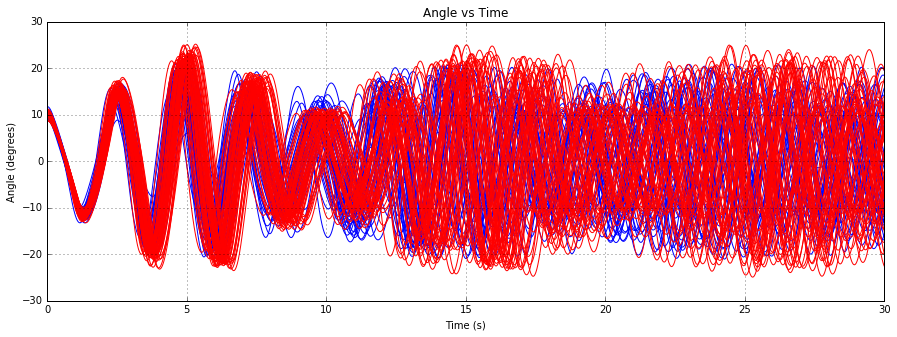

In [18]:
# Plot angles in degrees
plt.figure( figsize=(15, 5) )
plt.title('Angle vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (degrees)')
plt.grid()

# Plot successes
(rowCount, colCount) = angleData.shape
for colNum in range(colCount):
    radianAngles = angleData.iloc[:, colNum].values
    degreeAngles = [ math.degrees(x) for x in radianAngles ]
    plt.plot(t, degreeAngles, 'b') 
  
# Plot failures
(rowCount, colCount) = angleFailureData.shape  
for colNum in range(colCount):
    radianAngles = angleFailureData.iloc[:, colNum].values
    degreeAngles = [ math.degrees(x) for x in radianAngles ]
    plt.plot(t, degreeAngles, 'r')

plt.savefig('AngleDegreesPlot.png')   

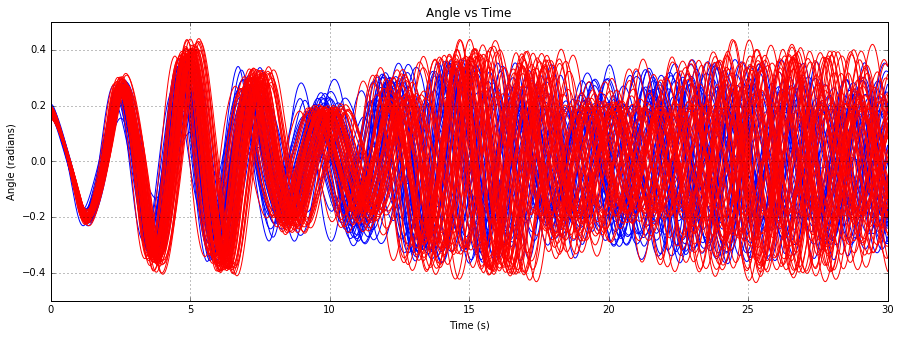

In [19]:
# Plot angles in radians
plt.figure( figsize=(15, 5) )
plt.title('Angle vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Angle (radians)')
plt.grid()

# Plot successes
(rowCount, colCount) = angleData.shape
for colNum in range(colCount):
    plt.plot(t, angleData.iloc[:, colNum], 'b')     
  
# Plot failures
(rowCount, colCount) = angleFailureData.shape  
for colNum in range(colCount):
    plt.plot(t, angleFailureData.iloc[:, colNum], 'r')

plt.savefig('AngleRadiansPlot.png')   

### Plotting stretch over time

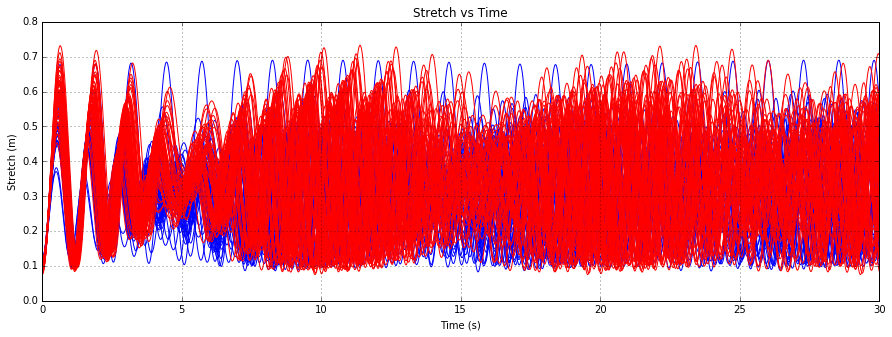

In [20]:
plt.figure( figsize=(15,5) )
plt.title('Stretch vs Time')
plt.xlabel('Time (s)')
plt.ylabel('Stretch (m)')
plt.grid()

# Plot successes
(rowCount, colCount) = stretchData.shape
for colNum in range(colCount):
    col = stretchData.iloc[:, colNum]
    plt.plot(t, col, 'b')
  
# Plot failures
(rowCount, colCount) = stretchFailureData.shape  
for colNum in range(colCount):
    col = stretchFailureData.iloc[:, colNum]
    plt.plot(t, col, 'r')

plt.savefig('StretchPlot.png')

### Saving data frames

In [21]:
stretchData.to_csv('StretchSuccessData.csv', encoding='utf-8')
stretchFailureData.to_csv('StretchFailureData.csv', encoding='utf-8')  
angleData.to_csv('AngleSuccessData.csv', encoding='utf-8')
angleFailureData.to_csv('AngleFailureData.csv', encoding='utf-8')
parameterData.to_csv('ParameterData.csv', encoding='utf-8')